## The following is the reference
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from pandas import read_csv

Using TensorFlow backend.
/Users/zhouwenbin/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhouwenbin/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhouwenbin/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhou

In [2]:
df1 =  pd.read_csv("/Users/zhouwenbin/Documents/crypto/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv")

In [3]:
df1 = df1.rename(columns={"Timestamp":"Date"})
df1["Date"] = pd.to_datetime(df1["Date"],unit="s")

In [4]:
df1.tail(2)

,Date,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4363455,2020-04-21 23:59:00,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.19509
4363456,2020-04-22 00:00:00,6850.60,6850.60,6850.60,6850.60,0.014436,98.896906,6850.60000


In [5]:
df2=df1[(df1['Date'] >='2020-03-01 00:00:00') & (df1['Date'] <= '2020-03-31 23:59:00')]

In [6]:
df2=df2[["Date","Close", "Volume_(BTC)"]]

In [7]:
df2.dropna()

,Date,Close,Volume_(BTC)
4288576,2020-03-01 00:00:00,8556.65,15.188068
4288577,2020-03-01 00:01:00,8554.50,2.542385
4288578,2020-03-01 00:02:00,8561.72,43.567942
4288579,2020-03-01 00:03:00,8558.42,3.910809
4288580,2020-03-01 00:04:00,8569.18,0.120000
...,...,...,...
4333211,2020-03-31 23:55:00,6440.21,0.257798
4333212,2020-03-31 23:56:00,6431.51,2.591804
4333213,2020-03-31 23:57:00,6430.43,0.194366
4333214,2020-03-31 23:58:00,6426.46,0.195139


In [8]:
df2.head(2)

,Date,Close,Volume_(BTC)
4288576,2020-03-01 00:00:00,8556.65,15.188068
4288577,2020-03-01 00:01:00,8554.50,2.542385


In [9]:
values = df2.values

In [10]:
print(values)

[[Timestamp('2020-03-01 00:00:00') 8556.65 15.18806767]
 [Timestamp('2020-03-01 00:01:00') 8554.5 2.54238498]
 [Timestamp('2020-03-01 00:02:00') 8561.72 43.56794154]
 ...
 [Timestamp('2020-03-31 23:57:00') 6430.43 0.19436595]
 [Timestamp('2020-03-31 23:58:00') 6426.46 0.1951393]
 [Timestamp('2020-03-31 23:59:00') 6421.14 0.20248999]]


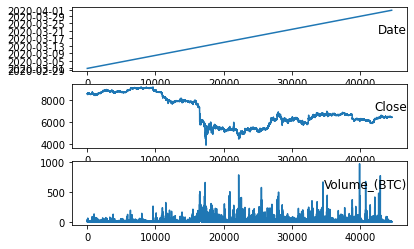

In [11]:
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df2.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Here is created input columns which are (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Here is created output/forecast column which are (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [13]:
df3=df2
df3=df2[["Close","Volume_(BTC)"]]
values=df3.values
values = values.astype('float32')
print(values)


[[8.5566504e+03 1.5188067e+01]
 [8.5545000e+03 2.5423849e+00]
 [8.5617197e+03 4.3567940e+01]
 ...
 [6.4304302e+03 1.9436595e-01]
 [6.4264600e+03 1.9513930e-01]
 [6.4211401e+03 2.0248999e-01]]


In [14]:
values[0,1]

15.188067

In [15]:
# Dataset values are normalized by using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
print(scaled)

[[8.7876391e-01 1.5756626e-02]
 [8.7836123e-01 2.6375577e-03]
 [8.7971342e-01 4.5198888e-02]
 ...
 [4.8051488e-01 2.0164177e-04]
 [4.7977114e-01 2.0244408e-04]
 [4.7877479e-01 2.1006993e-04]]


In [16]:
# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.878764   0.015757  0.878361  0.002638
2   0.878361   0.002638  0.879713  0.045199
3   0.879713   0.045199  0.879095  0.004057
4   0.879095   0.004057  0.881111  0.000124
5   0.881111   0.000124  0.881021  0.001360


In [17]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)

In [18]:
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.878764   0.015757  0.878361
2   0.878361   0.002638  0.879713
3   0.879713   0.045199  0.879095
4   0.879095   0.004057  0.881111
5   0.881111   0.000124  0.881021


In [19]:
# Dataset is splitted into two groups which are train and test sets
values = reframed.values 
train_size = int(len(values)*0.70)
train = values[:train_size,:]
test = values[train_size:,:]

In [20]:
train.shape

(30757, 3)

In [21]:
train[0]

array([0.8787639 , 0.01575663, 0.8783612 ], dtype=float32)

In [22]:
test.shape

(13183, 3)

In [23]:
# Splitted datasets are splitted to trainX, trainY, testX and testY 
trainX, trainY = train[:,:-1], train[:,-1]
testX, testY = test[:,:-1], test[:,-1]
print(trainY)

[0.8783612  0.8797134  0.87909544 ... 0.41105497 0.41115987 0.41214514]


In [24]:
trainX.shape

(30757, 2)

In [25]:
trainX[0]

array([0.8787639 , 0.01575663], dtype=float32)

In [26]:
trainY.shape

(30757,)

In [27]:
trainY[0]

0.8783612

In [28]:
# Train and Test datasets are reshaped in 3D size to be used in LSTM
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))
print(trainX.shape, trainY.shape,testX.shape,testY.shape)

(30757, 1, 2) (30757,) (13183, 1, 2) (13183,)


In [29]:
testX.shape[2]

2

In [30]:
# LSTM model is created and adjusted neuron structure
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Dataset is trained by using trainX and trainY
history = model.fit(trainX, trainY, epochs=25, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 30757 samples, validate on 13183 samples
Epoch 1/25
 - 4s - loss: 0.0464 - val_loss: 0.0498
Epoch 2/25
 - 4s - loss: 0.0198 - val_loss: 0.0413
Epoch 3/25
 - 4s - loss: 0.0184 - val_loss: 0.0409
Epoch 4/25
 - 4s - loss: 0.0172 - val_loss: 0.0364
Epoch 5/25
 - 4s - loss: 0.0159 - val_loss: 0.0320
Epoch 6/25
 - 4s - loss: 0.0145 - val_loss: 0.0277
Epoch 7/25
 - 4s - loss: 0.0138 - val_loss: 0.0269
Epoch 8/25
 - 4s - loss: 0.0132 - val_loss: 0.0253
Epoch 9/25
 - 4s - loss: 0.0125 - val_loss: 0.0241
Epoch 10/25
 - 4s - loss: 0.0121 - val_loss: 0.0244
Epoch 11/25
 - 4s - loss: 0.0118 - val_loss: 0.0224
Epoch 12/25
 - 4s - loss: 0.0111 - val_loss: 0.0195
Epoch 13/25
 - 4s - loss: 0.0106 - val_loss: 0.0190
Epoch 14/25
 - 4s - loss: 0.0105 - val_loss: 0.0188
Epoch 15/25
 - 4s - loss: 0.0100 - val_loss: 0.0190
Epoch 16/25
 - 4s - loss: 0.0100 - val_loss: 0.0179
Epoch 17/25
 - 4s - loss: 0.0096 - val_loss: 0.0184
Epoch 18/25
 - 4s - loss: 0

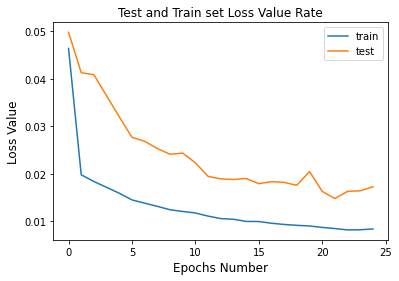

In [33]:

# Loss values are calculated for every training epoch and are visualized
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title("Test and Train set Loss Value Rate")
pyplot.xlabel('Epochs Number', fontsize=12)
pyplot.ylabel('Loss Value', fontsize=12)
pyplot.legend()
pyplot.show()

In [34]:
testX.shape

(13183, 1, 2)

In [35]:

# make a prediction
yhat = model.predict(testX)





In [36]:
testX = testX.reshape((testX.shape[0], testX.shape[2]))

In [37]:
testX.shape

(13183, 2)

In [38]:
testX[:, 1:].shape

(13183, 1)

In [39]:
yhat.shape

(13183, 1)

In [40]:
inv_yhat = concatenate((yhat, testX[:, 1:]), axis=1)

In [41]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [42]:
inv_yhat = inv_yhat[:,0]

In [43]:
testY = testY.reshape((len(testY), 1))

In [44]:
inv_y = concatenate((testY, testX[:, 1:]), axis=1)

In [45]:
inv_y = scaler.inverse_transform(inv_y)

In [46]:
inv_y = inv_y[:,0]

In [47]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 105.758


In [48]:
inv_y.shape

(13183,)

In [49]:
inv_yhat.shape

(13183,)

In [50]:
inv_yhat

array([6059.6104, 6045.348 , 6039.8223, ..., 6342.129 , 6341.3027,
       6338.2305], dtype=float32)

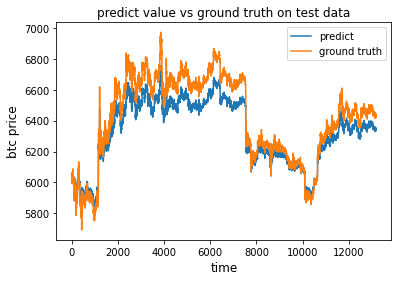

In [51]:
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='ground truth')
pyplot.title("predict value vs ground truth on test data")
pyplot.xlabel('time', fontsize=12)
pyplot.ylabel('btc price', fontsize=12)
pyplot.legend()
pyplot.show()

In [52]:
# new dataset is prepared
# I want to see how does the model performance when applied to new data set
df_new=df1[(df1['Date'] >='2020-04-01 00:00:00') & (df1['Date'] <= '2020-04-21 23:59:00')]

In [53]:

df_new = df_new[["Close","Volume_(BTC)"]]
values_new = df_new.values
values_new = values_new.astype('float32')
# print(values_new)

# Dataset values are normalized by using MinMax method
scaler_new = MinMaxScaler(feature_range=(0,1))
scaled_new = scaler_new.fit_transform(values_new)
# print(scaled_new)


# Normalized values are converted for supervised learning 
reframed_new = series_to_supervised(scaled_new,1,1)

# drop columns we don't want to predict
reframed_new.drop(reframed_new.columns[[3]], axis=1, inplace=True)
print(reframed_new.head())


   var1(t-1)  var2(t-1)   var1(t)
1   0.206613   0.001012  0.208896
2   0.208896   0.000715  0.207808
3   0.207808   0.002017  0.207685
4   0.207685   0.000021  0.208934
5   0.208934   0.000927  0.210903


In [54]:
values_new = reframed_new.values

In [55]:
len(values_new)

28301

In [56]:
test_new = values_new 

In [57]:
testX_new, testY_new = test_new[:,:-1], test_new[:,2]
testX_new  = testX_new.reshape((testX_new.shape[0],1,testX_new.shape[1]))

In [58]:
predict_new=model.predict(testX_new)


In [59]:
testY_new[0]

0.20889568

In [60]:
predict_new[0]

array([0.25380263], dtype=float32)

In [61]:
testX_new=testX_new.reshape((testX_new.shape[0], testX_new.shape[2]))
testX_new.shape

(28301, 2)

In [62]:
yhat_new = concatenate((predict_new, testX_new[:, 1:]), axis=1)

In [63]:
yhat_new=scaler.inverse_transform(yhat_new)

In [64]:
inv_yhat_new= yhat_new[:,0]

In [65]:
testY_new = testY_new.reshape((len(testY_new), 1))

In [66]:
inv_y_new = concatenate((testY_new, testX_new[:, 1:]), axis=1)

In [67]:
inv_y_new = scaler.inverse_transform(inv_y_new)

In [68]:
inv_y_new = inv_y_new[:,0]

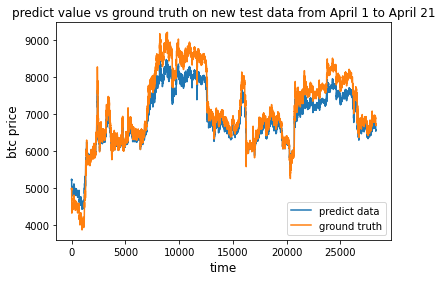

In [69]:
pyplot.plot(inv_yhat_new, label='predict data')
pyplot.plot(inv_y_new , label='ground truth')
pyplot.title("predict value vs ground truth on new test data from April 1 to April 21")
pyplot.xlabel('time', fontsize=12)
pyplot.ylabel('btc price', fontsize=12)
pyplot.legend()
pyplot.show()